In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/credit/creditcard.csv")
#data = data.drop(columns=['id'])
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data=(data-data.min())/(data.max()-data.min())

#data = data[:70000]

In [5]:
target = 'Class'

In [6]:
from imblearn.under_sampling import RandomUnderSampler

X = data.drop(columns=[target])
y = data[target]

sampling_strategy = 0.75

rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

X, y = rus.fit_resample(X, y) # type: ignore


In [7]:
y_series = pd.Series(y)

# Calculate the class distribution
class_distribution = y_series.value_counts(normalize=True) * 100

print(class_distribution)

0.0    57.142857
1.0    42.857143
Name: Class, dtype: float64


In [7]:
data = pd.concat([X, y], axis=1)
data.shape

(1148, 31)

In [8]:
#model_ctgan = CTGANSynthesizer(epochs=200, verbose=True)
#model_ctgan = DPCTGANSynthesizer(verbose=True)
model_ctgan = FPGANSynthesizer(epochs=200, verbose=True)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data, rate=0.75)

In [ ]:
from utils.utils import save_models
save_models(model_ctgan, '075fptgan200', 'credit')

In [ ]:
from utils.utils import load_models
model_ctgan = load_models('075fptgan200', 'credit')

In [ ]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [ ]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [ ]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.13063751]


## Fidelity

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = False)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = False)

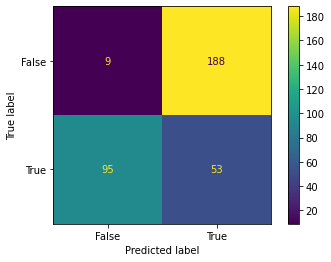

In [ ]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [ ]:
percentage = eval_fidelity(rr_pred, fr_pred)

In [ ]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.936231884057971
Accuracy of synthetic data:  0.19130434782608696


In [ ]:
from utils.fidelity import get_roc_auc
rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  0.9349190561119495
ROC AUC of synthetic data:  0.2137295925366991


## Final plot

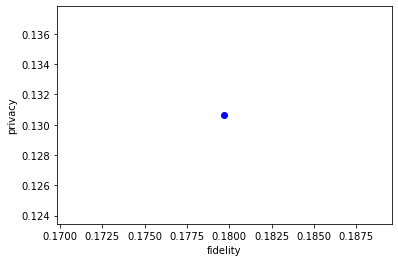

0.17971014492753623 [0.13063751]


In [ ]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)